# Sentiment Analysis on Customer Reviews using a Long Short_Term Memory neural network.

This notebook describes a sentiment analysis project run on data retrieved from: Kotzias, D. (2015). Sentiment Labelled Sentences [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C57604.

Connect to drive to access data:

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data:

In [2]:
import numpy as np
amazon = np.genfromtxt(
    "/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/amazon_cells_labelled.txt",
    delimiter='\t', dtype=str)
yelp = np.genfromtxt(
    "/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/yelp_labelled.txt",
    delimiter='\t', dtype=str)
imdb = np.genfromtxt(
    "/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/imdb_labelled.txt",
    delimiter='\t', dtype=str)
print(amazon.shape)
print(yelp.shape)
print(imdb.shape)
print(amazon[:5])
print(yelp[:5])
print(imdb[:5])
print(np.sum(amazon[:,1] == '1'))
print(np.sum(yelp[:,1] == '1'))
print(np.sum(imdb[:,1] == '1'))

(1000, 2)
(1000, 2)
(1000, 2)
[['So there is no way for me to plug it in here in the US unless I go by a converter.'
  '0']
 ['Good case, Excellent value.' '1']
 ['Great for the jawbone.' '1']
 ['Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!'
  '0']
 ['The mic is great.' '1']]
[['Wow... Loved this place.' '1']
 ['Crust is not good.' '0']
 ['Not tasty and the texture was just nasty.' '0']
 ['Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.'
  '1']
 ['The selection on the menu was great and so were the prices.' '1']]
[['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  '
  '0']
 ['Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  '
  '0']
 ['Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  '
  '

Create data frames:

In [3]:
import pandas as pd
df_amazon = pd.DataFrame(amazon, columns=['review', 'sentiment'])
df_yelp = pd.DataFrame(yelp, columns=['review', 'sentiment'])
df_imdb = pd.DataFrame(imdb, columns=['review', 'sentiment'])
print(df_amazon.head())
print(df_yelp.head())
print(df_imdb.head())

                                              review sentiment
0  So there is no way for me to plug it in here i...         0
1                        Good case, Excellent value.         1
2                             Great for the jawbone.         1
3  Tied to charger for conversations lasting more...         0
4                                  The mic is great.         1
                                              review sentiment
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
                                              review sentiment
0  A very, very, very slow-moving, aimless movie ...         0
1  Not sure who was more lost - the flat characte...         0
2  Attempting artiness with black & white and cle...   

Combine data into one data frame:

In [4]:
df = pd.concat([df_amazon, df_yelp, df_imdb])
df = df.reset_index(drop=True)
print(df.shape)
print(df.iloc[2999])
df

(3000, 2)
review       All in all its an insult to one's intelligence...
sentiment                                                    0
Name: 2999, dtype: object


,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I just got bored watching Jessice Lange take h...,0
2996,"Unfortunately, any virtue in this film's produ...",0
2997,"In a word, it is embarrassing.",0
2998,Exceptionally bad!,0


# Data exploration:

Visualize distribution of words:

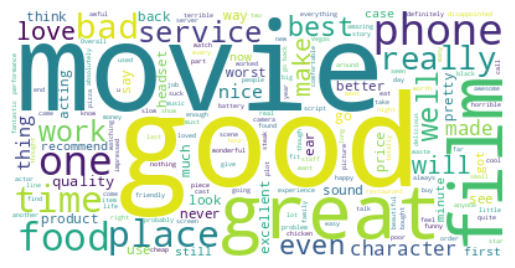

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color='white').generate(" ".join(df.review))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Determine vocabulary size (how many unique terms):

In [6]:
!pip install nltk # first time only

In [6]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt_tab')

# Tokenize reviews
tokenized_reviews = df.review.apply(lambda x: word_tokenize(x))
print(tokenized_reviews.head())

# Find unique tokens: combine tokens into a list then create set of unique tokens
all_tokens = [token for sublist in tokenized_reviews for token in sublist]
unique_tokens = set(all_tokens)
print(len(unique_tokens))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    [So, there, is, no, way, for, me, to, plug, it...
1                 [Good, case, ,, Excellent, value, .]
2                        [Great, for, the, jawbone, .]
3    [Tied, to, charger, for, conversations, lastin...
4                             [The, mic, is, great, .]
Name: review, dtype: object
6076


Check for special characters:

In [7]:
from nltk.tokenize import RegexpTokenizer

emoji = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
punctuation = r"[.?!'#&*]"
special = r"[\W\D\S]" # non-word, non-digit, non-whitespace
tokenizere = RegexpTokenizer(emoji)
print(len(tokenizere.tokenize(str(df))))
tokenizerp = RegexpTokenizer(punctuation)
print(len(tokenizerp.tokenize(str(df))))
tokenizers = RegexpTokenizer(special)
print(len(tokenizers.tokenize(str(df))))

2
31
816


Create and apply a function that achieves pre-processing goals of lemmatizing, removing stop-words, making all words lower case, keeping only alphanumeric characters:

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string

def preprocess_text(text):
  # Tokenize text and remove stop-words
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(text.lower())
  filtered_tokens = [token for token in tokens if token not in
                     stopwords.words('english')]

  # Lemmatise tokens
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  # Join tokens back into string
  string_text = ' '.join(lemmatized_tokens)

  # Remove punctuation
  string_text= string_text.translate(str.maketrans('','',string.punctuation))

  return string_text

# Apply pre-processing to reviews
df['review'] = df['review'].apply(preprocess_text)
print(df)

# Check vocabulary size after preprocessing
token_size = df['review'].apply(lambda x: len(x.split(' ')))
print(token_size.describe())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                 review sentiment
0                       way plug u unless go converter          0
1                           good case  excellent value          1
2                                        great jawbone          1
3     tied charger conversation lasting 45 minutesma...         0
4                                            mic great          1
...                                                 ...       ...
2995     got bored watching jessice lange take clothes          0
2996  unfortunately  virtue film s production work l...         0
2997                                word  embarrassing          0
2998                                 exceptionally bad          0
2999        insult one s intelligence huge waste money          0

[3000 rows x 2 columns]
count    3000.000000
mean        8.029667
std         5.022668
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        52.000000
Name: review, d

Build vocabulary:

In [9]:
class Vocabulary():
  def __init__(self, reviews):
    self.sentences = reviews
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    self.create_index()

  def create_index(self):
    for sent in self.sentences:
      self.vocab.update(sent.split(' '))

    # Sort vocabulary
    self.vocab = sorted(self.vocab)

    # Add padding token with index 0
    self.word2idx['<pad>'] = 0

    # Map word to index
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1

    # Map index to word
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

inputs = df['review']
vocabulary = Vocabulary(inputs)
vocab_size = len(vocabulary.word2idx)
print(vocabulary.word2idx)
print(vocabulary.idx2word)
print(vocab_size)

{'<pad>': 0, '': 1, '010': 2, '1': 3, '10': 4, '100': 5, '1010': 6, '11': 7, '110': 8, '1199': 9, '12': 10, '13': 11, '15': 12, '15lb': 13, '17': 14, '18': 15, '18th': 16, '1928': 17, '1947': 18, '1948': 19, '1949': 20, '1971': 21, '1973': 22, '1979': 23, '1980': 24, '1986': 25, '1995': 26, '1998': 27, '2': 28, '20': 29, '2000': 30, '2005': 31, '2006': 32, '2007': 33, '20th': 34, '20the': 35, '2160': 36, '23': 37, '24': 38, '25': 39, '2mp': 40, '3': 41, '30': 42, '325': 43, '34ths': 44, '35': 45, '350': 46, '375': 47, '3o': 48, '4': 49, '40': 50, '400': 51, '40min': 52, '42': 53, '45': 54, '5': 55, '50': 56, '5020': 57, '510': 58, '5320': 59, '54': 60, '5year': 61, '6': 62, '680': 63, '7': 64, '70': 65, '70000': 66, '700w': 67, '744': 68, '750': 69, '785': 70, '8': 71, '80': 72, '810': 73, '8125': 74, '815pm': 75, '8525': 76, '8530': 77, '8pm': 78, '9': 79, '90': 80, '910': 81, '95': 82, 'a': 83, 'aailiyah': 84, 'abandoned': 85, 'abhor': 86, 'ability': 87, 'able': 88, 'abound': 89, 'ab

Vectorize text:

In [10]:
review_tensor = [[vocabulary.word2idx[s] for s in es.split(' ')] for es in df['review']]
print(review_tensor[:5])

[[4627, 3138, 4388, 4448, 1840, 953, 1], [1851, 675, 1, 1490, 4515, 1], [1880, 2269, 1], [4254, 727, 952, 2373, 54, 2674, 3226, 1, 1], [2649, 1880, 1]]


Add padding:

In [11]:
def max_length(tensor):
  return max(len(t) for t in tensor)

max_length_review = max_length(review_tensor)

def add_padding(x, max_length):
  padded = np.zeros((max_length), dtype=np.int64)

  if len(x) > max_length:
    padded[:] = x[:max_length]
  else:
    padded[:len(x)] = x

  return padded

review_tensor = [add_padding(x, max_length_review) for x in review_tensor]
print(review_tensor[:1])

[array([4627, 3138, 4388, 4448, 1840,  953,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])]


Create torch tensors:

In [12]:
import torch

sentiment = torch.tensor(pd.to_numeric(df['sentiment'].values))
reviews = torch.tensor(review_tensor)
print(sentiment)
print(reviews)
print(sentiment.shape)
print(reviews.shape)

tensor([0, 1, 1,  ..., 0, 0, 0])
tensor([[4627, 3138, 4388,  ...,    0,    0,    0],
        [1851,  675,    1,  ...,    0,    0,    0],
        [1880, 2269,    1,  ...,    0,    0,    0],
        ...,
        [4715,    1, 1396,  ...,    0,    0,    0],
        [1495,  368,    1,  ...,    0,    0,    0],
        [2207, 2900, 3563,  ...,    0,    0,    0]])
torch.Size([3000])
torch.Size([3000, 52])


<ipython-input-12-e54037cde7dd>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  reviews = torch.tensor(review_tensor)


Split data into training, validation, and test sets:

In [13]:
from sklearn.model_selection import train_test_split
import random

random_state = 13
random.seed(random_state)

# Split into train and test (70%/30%)
X_train, X_test1, y_train, y_test1 = train_test_split(
    reviews, sentiment, test_size=0.30, stratify=sentiment, random_state = random_state)
# Split into test and validation (50/50 = 15%/15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_test1, y_test1, test_size=0.50, stratify=y_test1, random_state = random_state)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

# Save data sets
from numpy import asarray
from numpy import savetxt
X_train_array = asarray(X_train)
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/X_train.npy', X_train_array)
y_train_array = asarray(y_train)
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/y_train.npy', y_train_array)
X_val_array = asarray(X_val)
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/X_val.npy', X_val_array)
y_val_array = asarray(y_val)
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/y_val.npy', y_val_array)
X_test_array = asarray(X_test)
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/X_test.npy', X_test_array)
y_test_array = asarray(y_test)
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/data/y_test.npy', y_test_array)

torch.Size([2100, 52]) torch.Size([2100]) torch.Size([450, 52]) torch.Size([450]) torch.Size([450, 52]) torch.Size([450])


Create dataloaders:

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create tensor datasets
train_data = TensorDataset(X_train.type(torch.FloatTensor), y_train.type(torch.FloatTensor))
val_data = TensorDataset(X_val.type(torch.FloatTensor), y_val.type(torch.FloatTensor))
test_data = TensorDataset(X_test.type(torch.FloatTensor), y_test.type(torch.FloatTensor))

# Create dataloaders
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

Create model architecture:

In [57]:
!pip install torchinfo

In [61]:
import torch
import torch.nn as nn
from torchinfo import summary

# Build a GRU model
class gru_model(nn.Module):
  def __init__(self, max_features=4781):
    super().__init__()
    self.input_size = 1
    self.hidden_size = 128
    self.embedding = nn.Embedding(max_features, 128)
    self.gru = nn.GRU(128, 128, num_layers=2, batch_first=True, dropout = 0.3)
    self.fc = nn.Linear(self.hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
    x = self.embedding(x)
    x = x.view(batch_size, x.size(1), 128)
    out, _ = self.gru(x, h0)
    out = self.fc(out[:, -1, :])
    out = torch.sigmoid(out)
    return out

model = gru_model()
batch_size=50
summary(model, input_size=(batch_size, 52), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
gru_model                                [50, 1]                   --
├─Embedding: 1-1                         [50, 52, 128]             611,968
├─GRU: 1-2                               [50, 52, 128]             198,144
├─Linear: 1-3                            [50, 1]                   129
Total params: 810,241
Trainable params: 810,241
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 545.78
Input size (MB): 0.02
Forward/backward pass size (MB): 5.33
Params size (MB): 3.24
Estimated Total Size (MB): 8.59

Create early stopping class:

In [39]:
class EarlyStopper:
    def __init__(self, patience, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Create training function:

In [40]:
from torch.optim.lr_scheduler import ExponentialLR
from matplotlib import pyplot as plt
import os

# Create training function
def train_gru(model, criterion, optimizer, scheduler):
  for epoch in range(1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    # Iterate over training batches
    for reviews, sentiment in train_loader:
        optimizer.zero_grad()
        reviews = reviews.type(torch.LongTensor)
        output = model(reviews)
        outputs = (output > 0.5).float()
        outputs = outputs.squeeze(1)
        sentiment = sentiment.type(torch.FloatTensor).requires_grad_()
        loss = criterion(outputs, sentiment)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    train_loss = loss
    print(f"Training loss: {train_loss:.3f}")
    return(train_loss)

def validate_gru(model, criterion, optimizer, scheduler):
  with torch.no_grad():
    for epoch in range(1):
      model.eval()
      val_losses = []
      running_loss = 0.0
      running_corrects = 0
      preds = []
      actuals = []
      for reviews, sentiment in val_loader:
        reviews = reviews.type(torch.LongTensor)
        output = model(reviews)
        outputs = (output > 0.5).float()
        outputs = outputs.squeeze(1)
        sentiment = sentiment.type(torch.FloatTensor).requires_grad_()
        val_loss = criterion(outputs, sentiment)
        running_loss += val_loss.item()
        val_losses.append(val_loss.item())
        preds.append(outputs)
        actuals.append(sentiment)
        train_acc = torch.sum(outputs == sentiment)
        running_corrects += train_acc

      val_accuracy = train_acc / len(outputs) * 100
      print(f"Validation loss: {val_loss:.3f}")
      print(f"Validation accuracy: {val_accuracy:.3f}")
      return(val_loss, val_accuracy)



Create test function:

In [19]:
!pip install mlflow

In [51]:
import mlflow

# Set path for saving model
save_path = '/content/drive/MyDrive/Colab Notebooks/sentiment_analysis'

def train_model(lr, gamma, epochs):
  model = gru_model()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = ExponentialLR(optimizer, gamma=gamma)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  criterion = nn.BCELoss()
  train_losses = []
  val_losses = []
  accuracy = []
  counter = 0
  val_loss_min = None
  with mlflow.start_run():
    for epoch in range(epochs):
      counter += 1
      print("Epoch: ", epoch + 1)
      print("Learning rate: ", lr)
      print("Gamma: ", gamma)
      train_loss = train_gru(model, criterion, optimizer, scheduler)
      val_loss, val_accuracy = validate_gru(model, criterion, optimizer, scheduler)
      train_losses.append(train_loss.detach().numpy())
      val_losses.append(val_loss.detach().numpy())
      accuracy.append(val_accuracy.detach().numpy())
      scheduler.step(val_loss)

      # Include early stop if necessary
      early_stopper = EarlyStopper(patience=3)
      if early_stopper.early_stop(val_loss):
        print("We are at epoch:", epoch)
        break
      if val_loss_min is None or(
          (val_loss_min - val_loss) / val_loss_min > 0.01
          ):
        # Save weights
        filename = os.path.join(save_path, 'best_val_loss.pt')
        torch.save(model.state_dict(), filename)
        val_loss_min = val_loss

      # Log hyperparameters
      mlflow.log_param("learning_rate", lr)
      mlflow.log_param("epochs", epochs)
      mlflow.log_param("gamma", gamma)

      # Log metrics
      mlflow.log_metric("train_loss", train_loss)
      mlflow.log_metric("val_loss", val_loss)
      mlflow.log_metric("val_accuracy", val_accuracy)
      mlflow.log_artifact(filename)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Training and validation loss")
    plt.show()
    plt.plot(accuracy)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.show()
    return(model)
  mlflow.end_run()



Create grid for random search to explore hyperparameters:

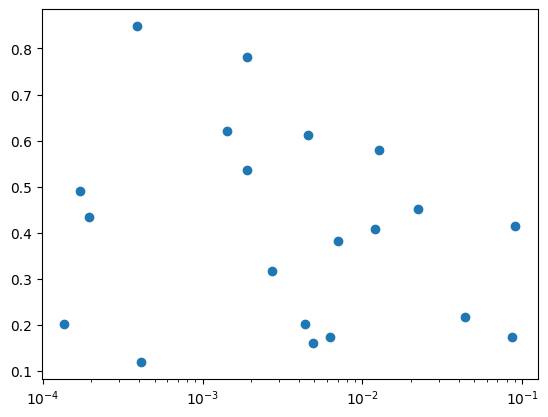

In [42]:
# Create random grid of learning rate and gamma
min_lr = 0.0001
max_lr = 0.1
min_gamma = 0.1
max_gamma = 0.9
n_grid = 20

# Sample learning rate log samples
lrs = 10**(np.random.uniform(np.log10(min_lr), np.log10(max_lr), n_grid))
# Uniformly sample gamma rate
gammas = 10**(np.random.uniform(np.log10(min_gamma), np.log10(max_gamma), n_grid))

# Plot grid
_ = plt.scatter(lrs, gammas)
_ = plt.xscale("log")

Test hyperparameters:

Epoch:  1
Learning rate:  0.022316826178686244
Gamma:  0.45233897412265345
Training loss: 52.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  2
Learning rate:  0.022316826178686244
Gamma:  0.45233897412265345
Training loss: 42.000
Validation loss: 66.000
Validation accuracy: 34.000
Epoch:  3
Learning rate:  0.022316826178686244
Gamma:  0.45233897412265345
Training loss: 52.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  4
Learning rate:  0.022316826178686244
Gamma:  0.45233897412265345
Training loss: 58.000
Validation loss: 40.000
Validation accuracy: 60.000
Epoch:  5
Learning rate:  0.022316826178686244
Gamma:  0.45233897412265345
Training loss: 56.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  6
Learning rate:  0.022316826178686244
Gamma:  0.45233897412265345
Training loss: 52.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  7
Learning rate:  0.022316826178686244
Gamma:  0.45233897412265345
Training loss: 48.000
Validatio

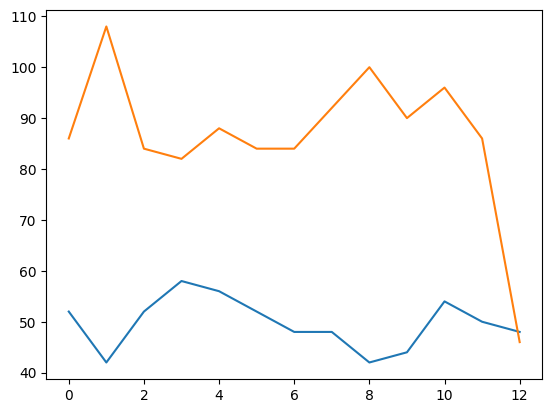

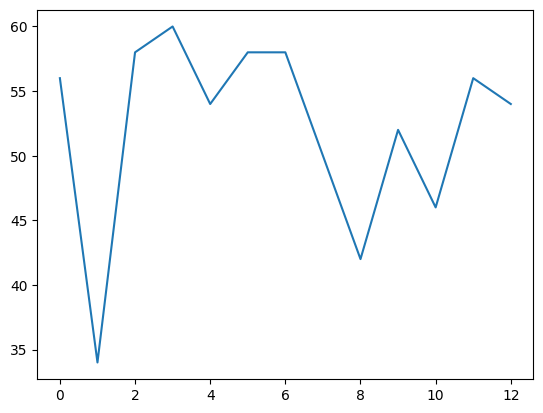

Epoch:  1
Learning rate:  0.004387482923685807
Gamma:  0.2018235322004844
Training loss: 56.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  2
Learning rate:  0.004387482923685807
Gamma:  0.2018235322004844
Training loss: 46.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  3
Learning rate:  0.004387482923685807
Gamma:  0.2018235322004844
Training loss: 40.000
Validation loss: 36.000
Validation accuracy: 64.000
Epoch:  4
Learning rate:  0.004387482923685807
Gamma:  0.2018235322004844
Training loss: 50.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  5
Learning rate:  0.004387482923685807
Gamma:  0.2018235322004844
Training loss: 44.000
Validation loss: 58.000
Validation accuracy: 42.000
Epoch:  6
Learning rate:  0.004387482923685807
Gamma:  0.2018235322004844
Training loss: 44.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  7
Learning rate:  0.004387482923685807
Gamma:  0.2018235322004844
Training loss: 58.000
Validation loss:

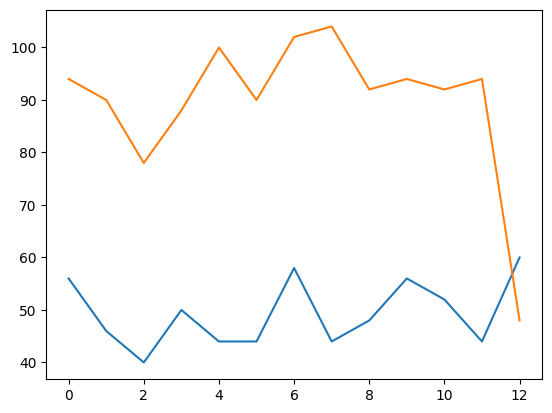

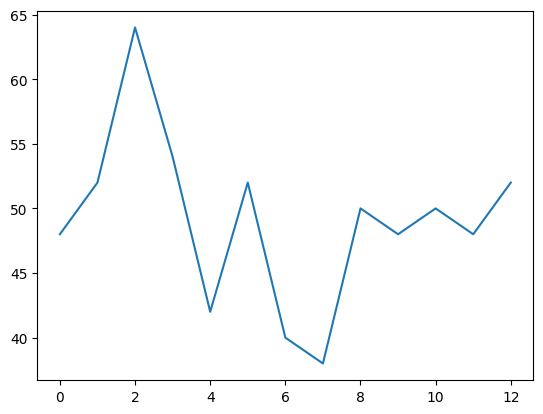

Epoch:  1
Learning rate:  0.0070601478326960615
Gamma:  0.3828911208942776
Training loss: 46.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  2
Learning rate:  0.0070601478326960615
Gamma:  0.3828911208942776
Training loss: 72.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  3
Learning rate:  0.0070601478326960615
Gamma:  0.3828911208942776
Training loss: 54.000
Validation loss: 36.000
Validation accuracy: 64.000
Epoch:  4
Learning rate:  0.0070601478326960615
Gamma:  0.3828911208942776
Training loss: 54.000
Validation loss: 60.000
Validation accuracy: 40.000
Epoch:  5
Learning rate:  0.0070601478326960615
Gamma:  0.3828911208942776
Training loss: 38.000
Validation loss: 58.000
Validation accuracy: 42.000
Epoch:  6
Learning rate:  0.0070601478326960615
Gamma:  0.3828911208942776
Training loss: 56.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  7
Learning rate:  0.0070601478326960615
Gamma:  0.3828911208942776
Training loss: 38.000
Validatio

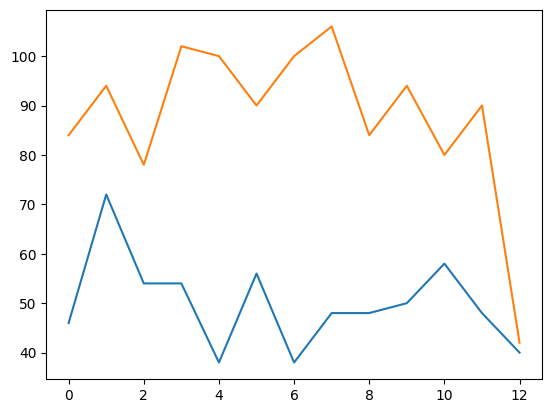

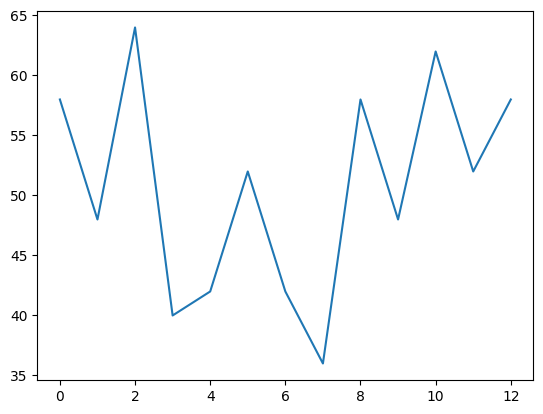

Epoch:  1
Learning rate:  0.012054094276954601
Gamma:  0.4088970222539037
Training loss: 56.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  2
Learning rate:  0.012054094276954601
Gamma:  0.4088970222539037
Training loss: 54.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  3
Learning rate:  0.012054094276954601
Gamma:  0.4088970222539037
Training loss: 42.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  4
Learning rate:  0.012054094276954601
Gamma:  0.4088970222539037
Training loss: 60.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  5
Learning rate:  0.012054094276954601
Gamma:  0.4088970222539037
Training loss: 48.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  6
Learning rate:  0.012054094276954601
Gamma:  0.4088970222539037
Training loss: 46.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  7
Learning rate:  0.012054094276954601
Gamma:  0.4088970222539037
Training loss: 50.000
Validation loss:

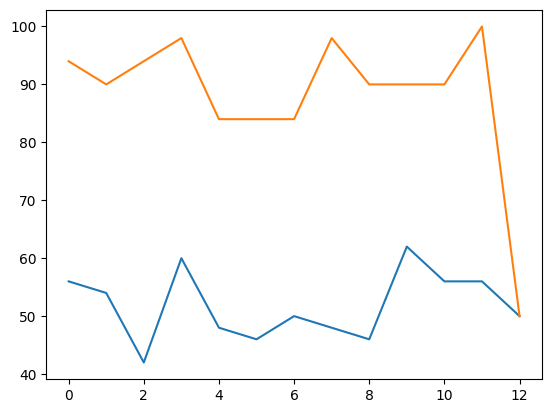

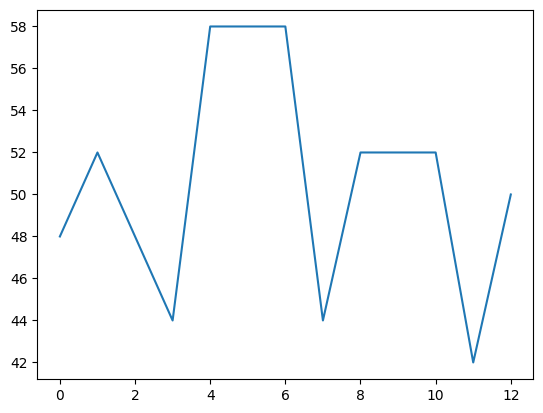

Epoch:  1
Learning rate:  0.09035022236890915
Gamma:  0.41487127499226834
Training loss: 66.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  2
Learning rate:  0.09035022236890915
Gamma:  0.41487127499226834
Training loss: 50.000
Validation loss: 64.000
Validation accuracy: 36.000
Epoch:  3
Learning rate:  0.09035022236890915
Gamma:  0.41487127499226834
Training loss: 50.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  4
Learning rate:  0.09035022236890915
Gamma:  0.41487127499226834
Training loss: 58.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  5
Learning rate:  0.09035022236890915
Gamma:  0.41487127499226834
Training loss: 50.000
Validation loss: 38.000
Validation accuracy: 62.000
Epoch:  6
Learning rate:  0.09035022236890915
Gamma:  0.41487127499226834
Training loss: 40.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  7
Learning rate:  0.09035022236890915
Gamma:  0.41487127499226834
Training loss: 46.000
Validation loss:

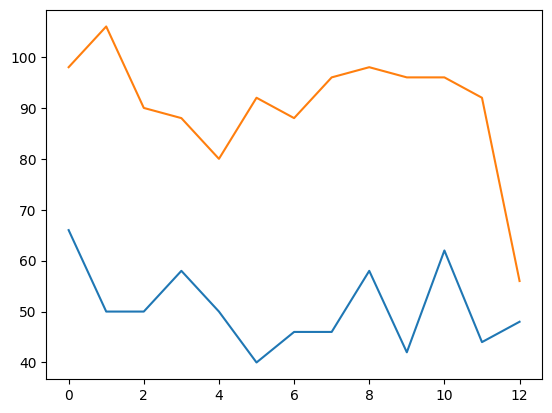

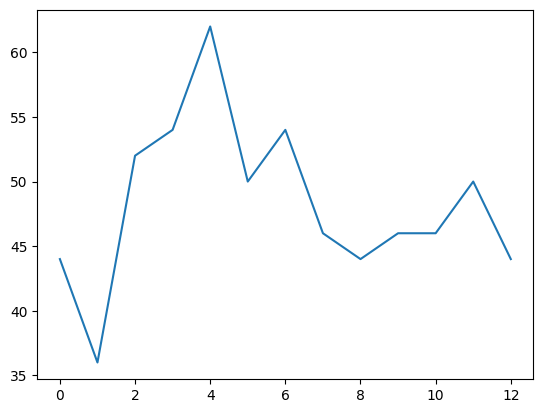

Epoch:  1
Learning rate:  0.006215670865446965
Gamma:  0.17404998757115886
Training loss: 42.000
Validation loss: 40.000
Validation accuracy: 60.000
Epoch:  2
Learning rate:  0.006215670865446965
Gamma:  0.17404998757115886
Training loss: 52.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  3
Learning rate:  0.006215670865446965
Gamma:  0.17404998757115886
Training loss: 40.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  4
Learning rate:  0.006215670865446965
Gamma:  0.17404998757115886
Training loss: 52.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  5
Learning rate:  0.006215670865446965
Gamma:  0.17404998757115886
Training loss: 48.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  6
Learning rate:  0.006215670865446965
Gamma:  0.17404998757115886
Training loss: 58.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  7
Learning rate:  0.006215670865446965
Gamma:  0.17404998757115886
Training loss: 54.000
Validatio

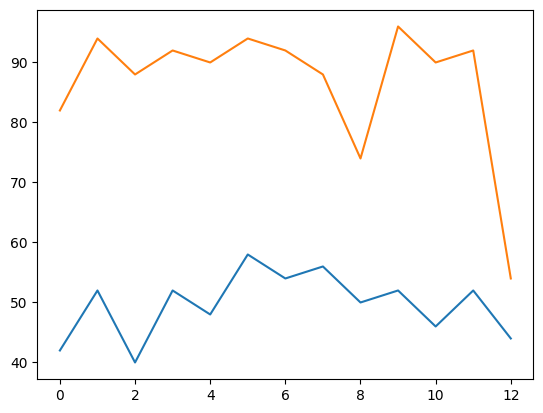

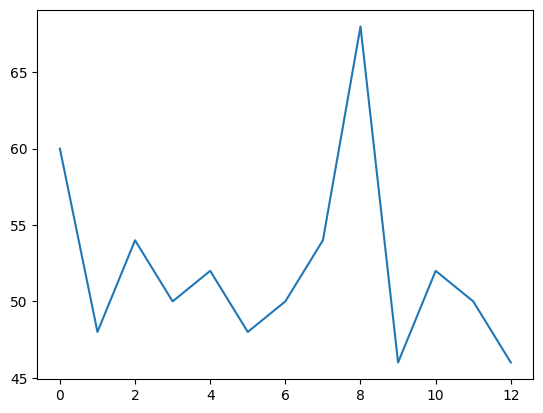

Epoch:  1
Learning rate:  0.0001705291735077551
Gamma:  0.4910365419648879
Training loss: 56.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  2
Learning rate:  0.0001705291735077551
Gamma:  0.4910365419648879
Training loss: 46.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  3
Learning rate:  0.0001705291735077551
Gamma:  0.4910365419648879
Training loss: 38.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  4
Learning rate:  0.0001705291735077551
Gamma:  0.4910365419648879
Training loss: 42.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  5
Learning rate:  0.0001705291735077551
Gamma:  0.4910365419648879
Training loss: 46.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  6
Learning rate:  0.0001705291735077551
Gamma:  0.4910365419648879
Training loss: 50.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  7
Learning rate:  0.0001705291735077551
Gamma:  0.4910365419648879
Training loss: 52.000
Validatio

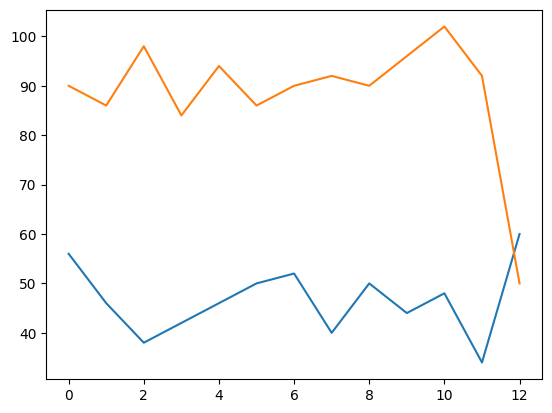

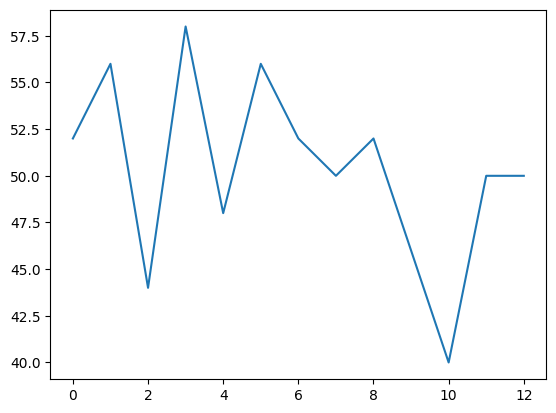

Epoch:  1
Learning rate:  0.08586809318749165
Gamma:  0.1743105149475645
Training loss: 46.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  2
Learning rate:  0.08586809318749165
Gamma:  0.1743105149475645
Training loss: 64.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  3
Learning rate:  0.08586809318749165
Gamma:  0.1743105149475645
Training loss: 48.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  4
Learning rate:  0.08586809318749165
Gamma:  0.1743105149475645
Training loss: 48.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  5
Learning rate:  0.08586809318749165
Gamma:  0.1743105149475645
Training loss: 50.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  6
Learning rate:  0.08586809318749165
Gamma:  0.1743105149475645
Training loss: 52.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  7
Learning rate:  0.08586809318749165
Gamma:  0.1743105149475645
Training loss: 46.000
Validation loss: 48.000

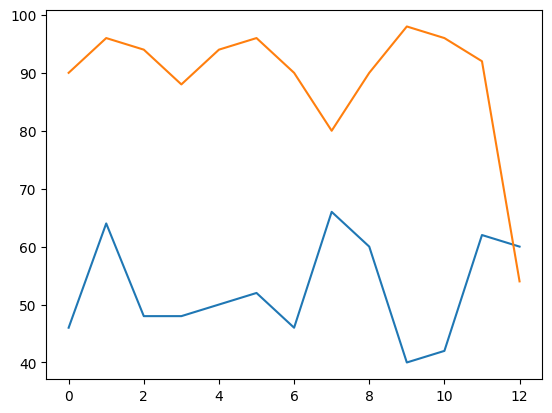

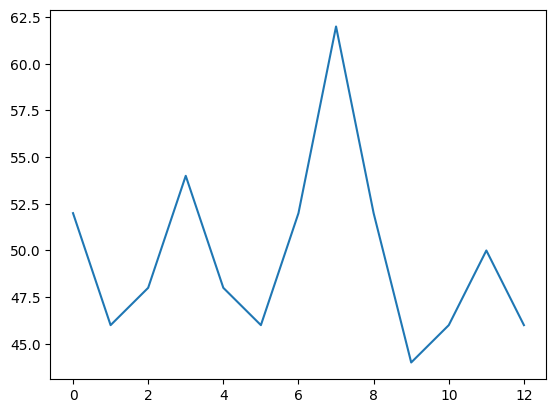

Epoch:  1
Learning rate:  0.004587064286748894
Gamma:  0.6132105332970637
Training loss: 38.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  2
Learning rate:  0.004587064286748894
Gamma:  0.6132105332970637
Training loss: 50.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  3
Learning rate:  0.004587064286748894
Gamma:  0.6132105332970637
Training loss: 62.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  4
Learning rate:  0.004587064286748894
Gamma:  0.6132105332970637
Training loss: 62.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  5
Learning rate:  0.004587064286748894
Gamma:  0.6132105332970637
Training loss: 52.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  6
Learning rate:  0.004587064286748894
Gamma:  0.6132105332970637
Training loss: 54.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  7
Learning rate:  0.004587064286748894
Gamma:  0.6132105332970637
Training loss: 56.000
Validation loss:

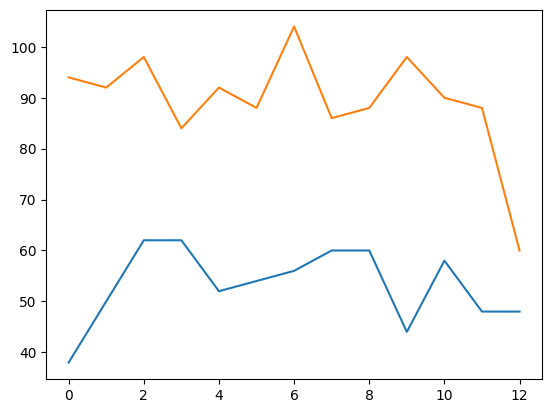

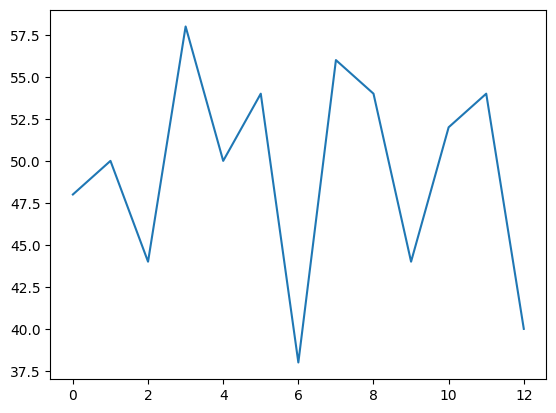

Epoch:  1
Learning rate:  0.0018879442660669561
Gamma:  0.7807348688168401
Training loss: 46.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  2
Learning rate:  0.0018879442660669561
Gamma:  0.7807348688168401
Training loss: 54.000
Validation loss: 40.000
Validation accuracy: 60.000
Epoch:  3
Learning rate:  0.0018879442660669561
Gamma:  0.7807348688168401
Training loss: 54.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  4
Learning rate:  0.0018879442660669561
Gamma:  0.7807348688168401
Training loss: 52.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  5
Learning rate:  0.0018879442660669561
Gamma:  0.7807348688168401
Training loss: 54.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  6
Learning rate:  0.0018879442660669561
Gamma:  0.7807348688168401
Training loss: 52.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  7
Learning rate:  0.0018879442660669561
Gamma:  0.7807348688168401
Training loss: 50.000
Validatio

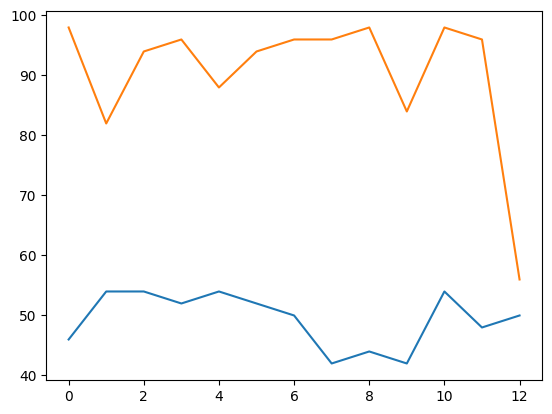

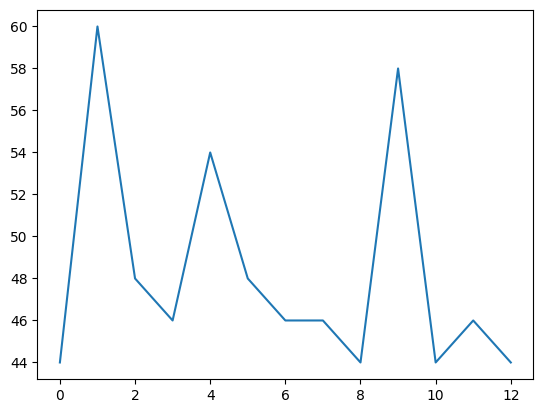

Epoch:  1
Learning rate:  0.0026943826958943933
Gamma:  0.31688775691311516
Training loss: 54.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  2
Learning rate:  0.0026943826958943933
Gamma:  0.31688775691311516
Training loss: 52.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  3
Learning rate:  0.0026943826958943933
Gamma:  0.31688775691311516
Training loss: 44.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  4
Learning rate:  0.0026943826958943933
Gamma:  0.31688775691311516
Training loss: 60.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  5
Learning rate:  0.0026943826958943933
Gamma:  0.31688775691311516
Training loss: 52.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  6
Learning rate:  0.0026943826958943933
Gamma:  0.31688775691311516
Training loss: 54.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  7
Learning rate:  0.0026943826958943933
Gamma:  0.31688775691311516
Training loss: 48.000
Va

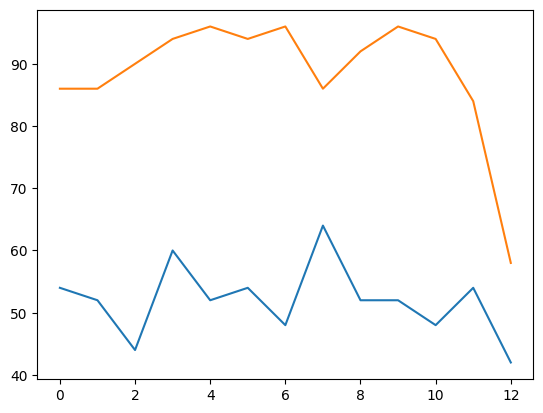

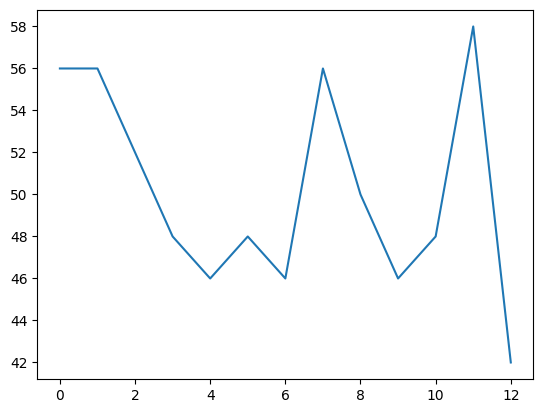

Epoch:  1
Learning rate:  0.0001952301269815164
Gamma:  0.4336841553629685
Training loss: 48.000
Validation loss: 36.000
Validation accuracy: 64.000
Epoch:  2
Learning rate:  0.0001952301269815164
Gamma:  0.4336841553629685
Training loss: 50.000
Validation loss: 40.000
Validation accuracy: 60.000
Epoch:  3
Learning rate:  0.0001952301269815164
Gamma:  0.4336841553629685
Training loss: 46.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  4
Learning rate:  0.0001952301269815164
Gamma:  0.4336841553629685
Training loss: 58.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  5
Learning rate:  0.0001952301269815164
Gamma:  0.4336841553629685
Training loss: 50.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  6
Learning rate:  0.0001952301269815164
Gamma:  0.4336841553629685
Training loss: 56.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  7
Learning rate:  0.0001952301269815164
Gamma:  0.4336841553629685
Training loss: 50.000
Validatio

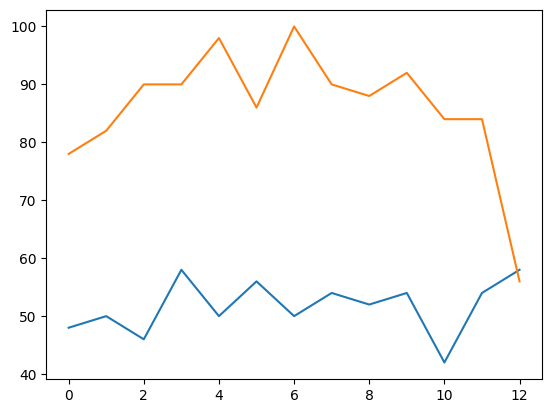

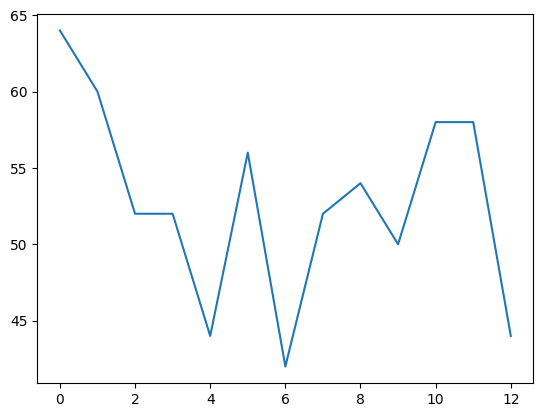

Epoch:  1
Learning rate:  0.004909385356307175
Gamma:  0.16023904764576566
Training loss: 42.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  2
Learning rate:  0.004909385356307175
Gamma:  0.16023904764576566
Training loss: 48.000
Validation loss: 40.000
Validation accuracy: 60.000
Epoch:  3
Learning rate:  0.004909385356307175
Gamma:  0.16023904764576566
Training loss: 44.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  4
Learning rate:  0.004909385356307175
Gamma:  0.16023904764576566
Training loss: 48.000
Validation loss: 36.000
Validation accuracy: 64.000
Epoch:  5
Learning rate:  0.004909385356307175
Gamma:  0.16023904764576566
Training loss: 42.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  6
Learning rate:  0.004909385356307175
Gamma:  0.16023904764576566
Training loss: 44.000
Validation loss: 58.000
Validation accuracy: 42.000
Epoch:  7
Learning rate:  0.004909385356307175
Gamma:  0.16023904764576566
Training loss: 62.000
Validatio

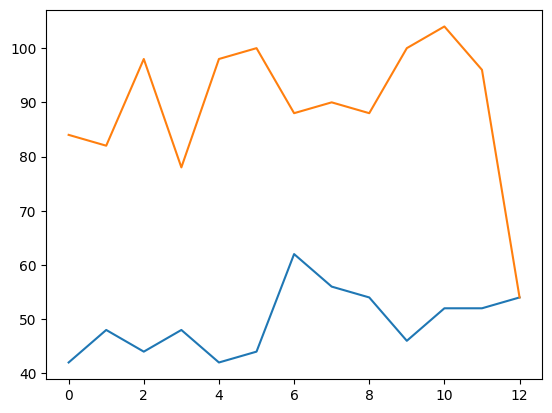

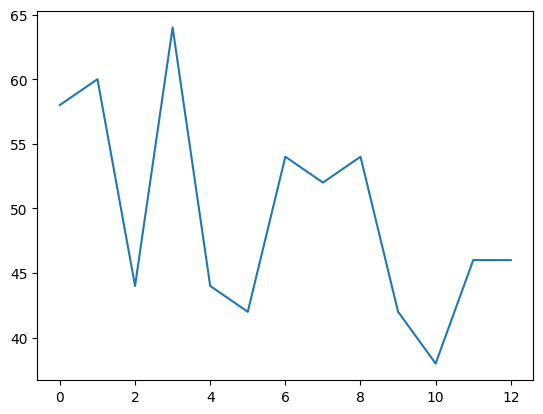

Epoch:  1
Learning rate:  0.0018935354478253888
Gamma:  0.5362826326914485
Training loss: 46.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  2
Learning rate:  0.0018935354478253888
Gamma:  0.5362826326914485
Training loss: 54.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  3
Learning rate:  0.0018935354478253888
Gamma:  0.5362826326914485
Training loss: 58.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  4
Learning rate:  0.0018935354478253888
Gamma:  0.5362826326914485
Training loss: 50.000
Validation loss: 40.000
Validation accuracy: 60.000
Epoch:  5
Learning rate:  0.0018935354478253888
Gamma:  0.5362826326914485
Training loss: 46.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  6
Learning rate:  0.0018935354478253888
Gamma:  0.5362826326914485
Training loss: 52.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  7
Learning rate:  0.0018935354478253888
Gamma:  0.5362826326914485
Training loss: 50.000
Validatio

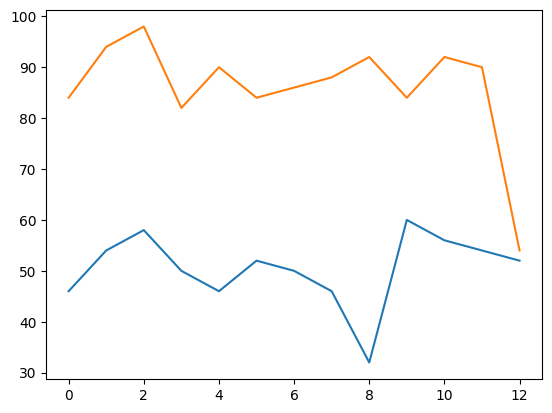

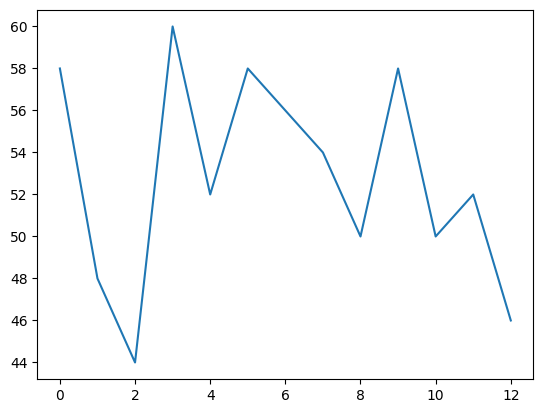

Epoch:  1
Learning rate:  0.00013579563096627575
Gamma:  0.20262116990535334
Training loss: 40.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  2
Learning rate:  0.00013579563096627575
Gamma:  0.20262116990535334
Training loss: 50.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  3
Learning rate:  0.00013579563096627575
Gamma:  0.20262116990535334
Training loss: 54.000
Validation loss: 58.000
Validation accuracy: 42.000
Epoch:  4
Learning rate:  0.00013579563096627575
Gamma:  0.20262116990535334
Training loss: 50.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  5
Learning rate:  0.00013579563096627575
Gamma:  0.20262116990535334
Training loss: 44.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  6
Learning rate:  0.00013579563096627575
Gamma:  0.20262116990535334
Training loss: 42.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  7
Learning rate:  0.00013579563096627575
Gamma:  0.20262116990535334
Training loss: 44

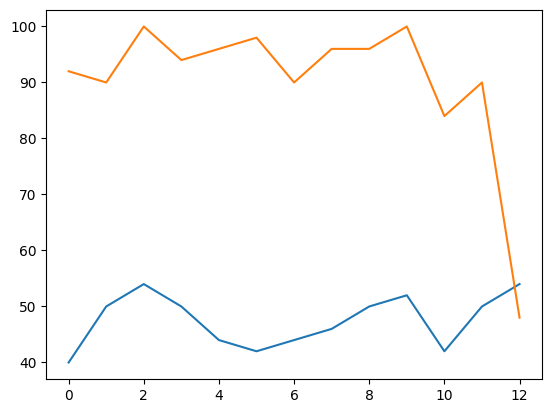

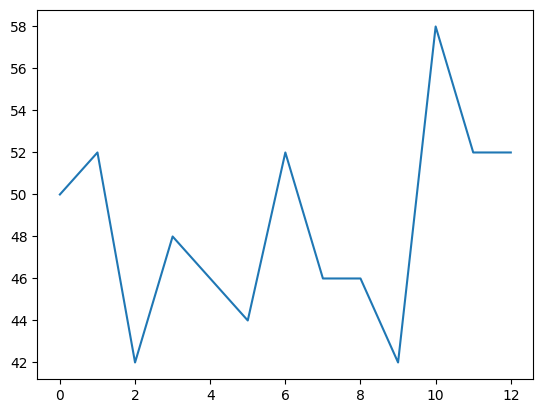

Epoch:  1
Learning rate:  0.0003883757302366547
Gamma:  0.8491174304498033
Training loss: 50.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  2
Learning rate:  0.0003883757302366547
Gamma:  0.8491174304498033
Training loss: 54.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  3
Learning rate:  0.0003883757302366547
Gamma:  0.8491174304498033
Training loss: 42.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  4
Learning rate:  0.0003883757302366547
Gamma:  0.8491174304498033
Training loss: 46.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  5
Learning rate:  0.0003883757302366547
Gamma:  0.8491174304498033
Training loss: 46.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  6
Learning rate:  0.0003883757302366547
Gamma:  0.8491174304498033
Training loss: 50.000
Validation loss: 58.000
Validation accuracy: 42.000
Epoch:  7
Learning rate:  0.0003883757302366547
Gamma:  0.8491174304498033
Training loss: 54.000
Validatio

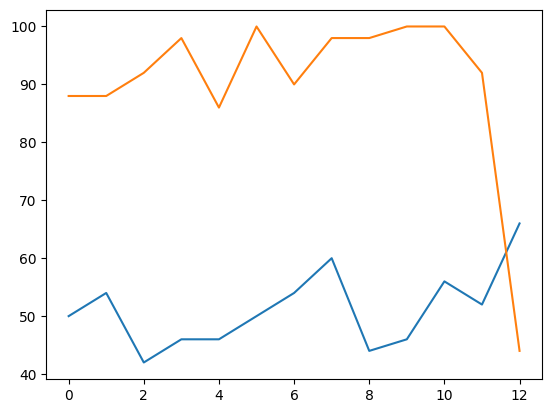

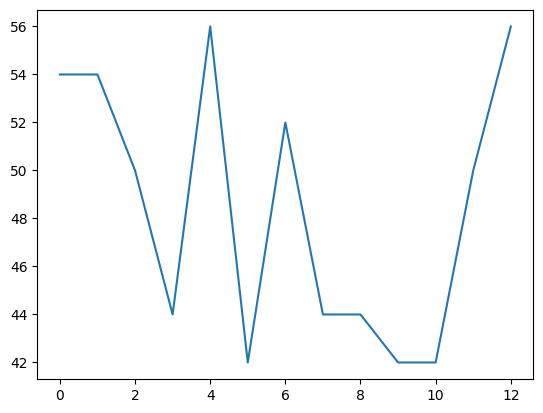

Epoch:  1
Learning rate:  0.00041101511419590884
Gamma:  0.11949460240048644
Training loss: 60.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  2
Learning rate:  0.00041101511419590884
Gamma:  0.11949460240048644
Training loss: 60.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  3
Learning rate:  0.00041101511419590884
Gamma:  0.11949460240048644
Training loss: 56.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  4
Learning rate:  0.00041101511419590884
Gamma:  0.11949460240048644
Training loss: 62.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  5
Learning rate:  0.00041101511419590884
Gamma:  0.11949460240048644
Training loss: 46.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  6
Learning rate:  0.00041101511419590884
Gamma:  0.11949460240048644
Training loss: 46.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  7
Learning rate:  0.00041101511419590884
Gamma:  0.11949460240048644
Training loss: 60

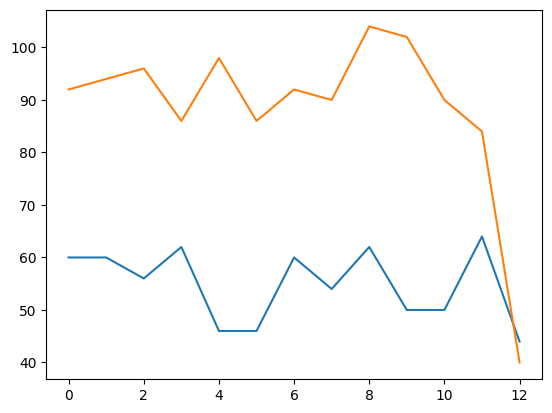

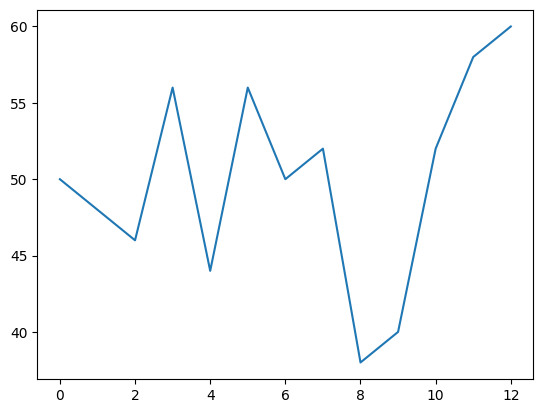

Epoch:  1
Learning rate:  0.012758785010588641
Gamma:  0.5799670006827607
Training loss: 50.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  2
Learning rate:  0.012758785010588641
Gamma:  0.5799670006827607
Training loss: 46.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  3
Learning rate:  0.012758785010588641
Gamma:  0.5799670006827607
Training loss: 44.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  4
Learning rate:  0.012758785010588641
Gamma:  0.5799670006827607
Training loss: 42.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  5
Learning rate:  0.012758785010588641
Gamma:  0.5799670006827607
Training loss: 40.000
Validation loss: 70.000
Validation accuracy: 30.000
Epoch:  6
Learning rate:  0.012758785010588641
Gamma:  0.5799670006827607
Training loss: 50.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  7
Learning rate:  0.012758785010588641
Gamma:  0.5799670006827607
Training loss: 56.000
Validation loss:

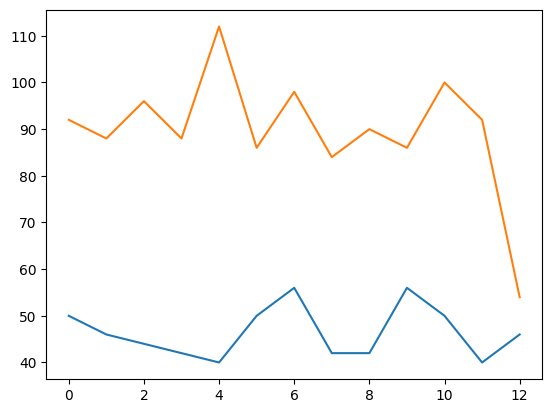

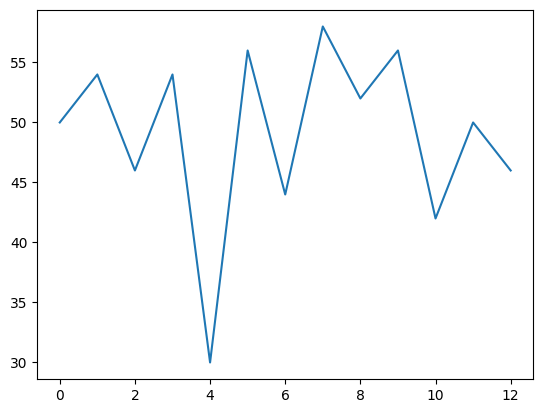

Epoch:  1
Learning rate:  0.04376882318658959
Gamma:  0.21589244249341877
Training loss: 60.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  2
Learning rate:  0.04376882318658959
Gamma:  0.21589244249341877
Training loss: 68.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  3
Learning rate:  0.04376882318658959
Gamma:  0.21589244249341877
Training loss: 50.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  4
Learning rate:  0.04376882318658959
Gamma:  0.21589244249341877
Training loss: 50.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  5
Learning rate:  0.04376882318658959
Gamma:  0.21589244249341877
Training loss: 44.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  6
Learning rate:  0.04376882318658959
Gamma:  0.21589244249341877
Training loss: 60.000
Validation loss: 62.000
Validation accuracy: 38.000
Epoch:  7
Learning rate:  0.04376882318658959
Gamma:  0.21589244249341877
Training loss: 46.000
Validation loss:

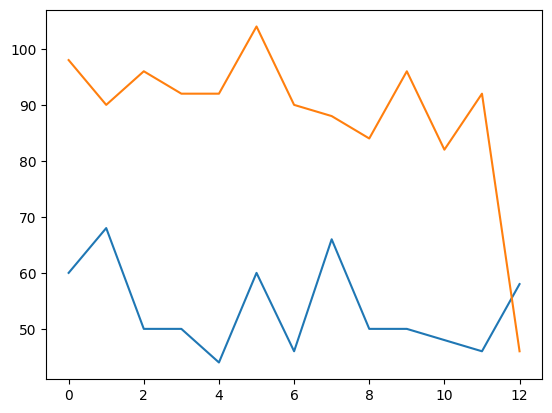

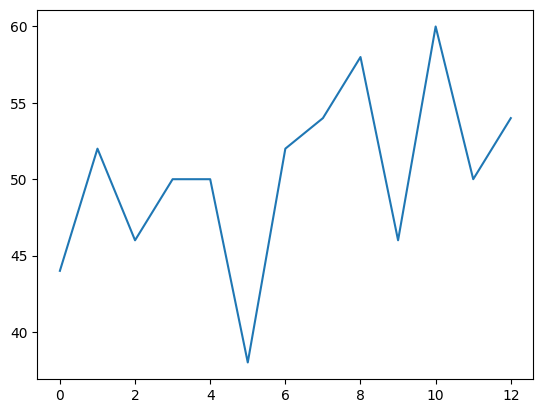

Epoch:  1
Learning rate:  0.0014143613661588568
Gamma:  0.620383970029788
Training loss: 44.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  2
Learning rate:  0.0014143613661588568
Gamma:  0.620383970029788
Training loss: 44.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  3
Learning rate:  0.0014143613661588568
Gamma:  0.620383970029788
Training loss: 56.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  4
Learning rate:  0.0014143613661588568
Gamma:  0.620383970029788
Training loss: 48.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  5
Learning rate:  0.0014143613661588568
Gamma:  0.620383970029788
Training loss: 50.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  6
Learning rate:  0.0014143613661588568
Gamma:  0.620383970029788
Training loss: 42.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  7
Learning rate:  0.0014143613661588568
Gamma:  0.620383970029788
Training loss: 38.000
Validation loss:

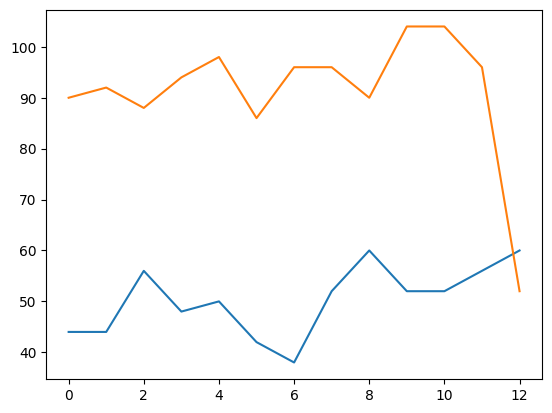

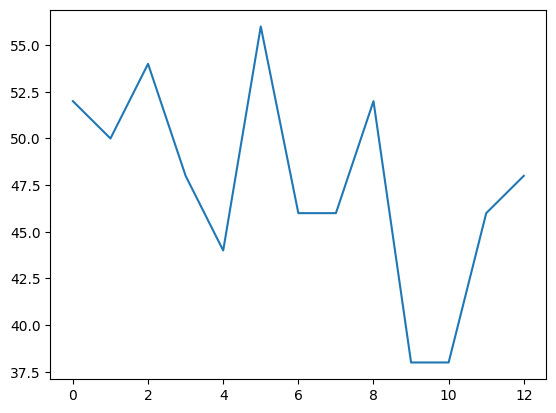

In [44]:
for lr, g in zip(lrs, gammas):
  train_model(lr=lr, gamma=g, epochs=13)

In [45]:
import mlflow

runs = mlflow.search_runs()
sorted_runs = runs[
    ["run_id",
     "params.learning_rate",
     "params.epochs",
     "params.gamma",
     "metrics.train_loss",
     "metrics.val_loss",
     "metrics.val_accuracy"
    ]
].sort_values(by="metrics.val_loss", ascending=True)
sorted_runs

,run_id,params.learning_rate,params.epochs,params.gamma,metrics.train_loss,metrics.val_loss,metrics.val_accuracy
34,06977365fa4b413fbb3a8f47b83d3155,0.09227491382282224,15,0.3236187379162702,54.0,32.0,68.0
111,9a18f7d620754783b78868e1a09fecf3,0.015536177212954234,5,0.5,62.0,32.0,68.0
52,d918c38b335d41cfadcc15a3b300fa3e,0.035594202868443614,10,0.7388264121750939,52.0,34.0,66.0
29,6b962ab682cf4bf8b1d21155dc2282d1,0.00445072039976717,15,0.28095492472780437,42.0,36.0,64.0
80,d5585477044c40a19597e0985a62ad04,0.0155,13,0.5,52.0,36.0,64.0
...,...,...,...,...,...,...,...
91,25f6c95fcc994de09366fe5b4f317ea5,0.022313702478056655,5,0.10505185639768984,60.0,64.0,36.0
20,2d00dbb9ea604bfcba4b3d7f08d38ee0,None,None,None,NaN,NaN,NaN
83,5492caa576c24255849ad2f979e87d5e,None,None,None,NaN,NaN,NaN
124,0b83125617da4b51ab587a03794b18c6,None,None,None,NaN,NaN,NaN


Train model to determine optimal number of epochs:

Epoch:  1
Learning rate:  0.016
Gamma:  0.281
Training loss: 54.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  2
Learning rate:  0.016
Gamma:  0.281


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training loss: 50.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  3
Learning rate:  0.016
Gamma:  0.281
Training loss: 52.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  4
Learning rate:  0.016
Gamma:  0.281
Training loss: 50.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  5
Learning rate:  0.016
Gamma:  0.281
Training loss: 48.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  6
Learning rate:  0.016
Gamma:  0.281
Training loss: 44.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  7
Learning rate:  0.016
Gamma:  0.281
Training loss: 48.000
Validation loss: 38.000
Validation accuracy: 62.000
Epoch:  8
Learning rate:  0.016
Gamma:  0.281
Training loss: 48.000
Validation loss: 48.000
Validation accuracy: 52.000
Epoch:  9
Learning rate:  0.016
Gamma:  0.281
Training loss: 50.000
Validation loss: 52.000
Validation accuracy: 48.000
Epoch:  10
Learning rate:  0.016
Gamma:  0.281
Training loss: 50.000
Validation loss: 

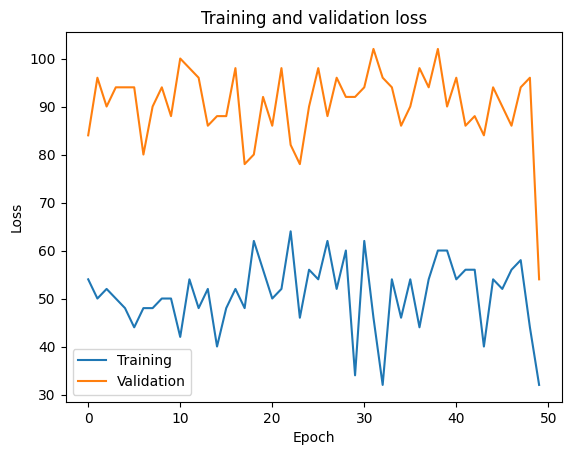

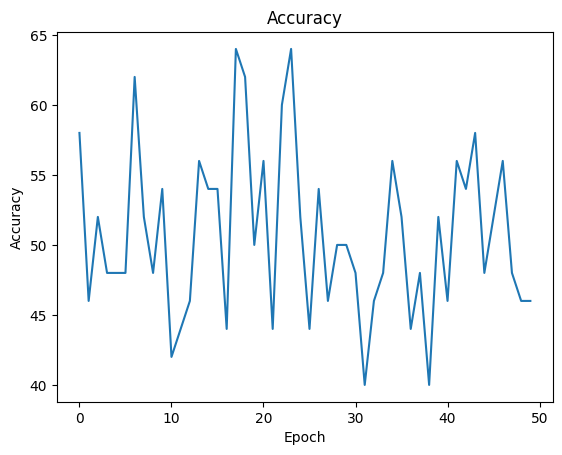

In [56]:
epoch_train = train_model(lr=0.016, gamma=0.281, epochs=50)

Train final model using best parameters:

Epoch:  1
Learning rate:  0.016
Gamma:  0.281
Training loss: 52.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  2
Learning rate:  0.016
Gamma:  0.281


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training loss: 40.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  3
Learning rate:  0.016
Gamma:  0.281
Training loss: 52.000
Validation loss: 46.000
Validation accuracy: 54.000
Epoch:  4
Learning rate:  0.016
Gamma:  0.281
Training loss: 50.000
Validation loss: 42.000
Validation accuracy: 58.000
Epoch:  5
Learning rate:  0.016
Gamma:  0.281
Training loss: 54.000
Validation loss: 56.000
Validation accuracy: 44.000
Epoch:  6
Learning rate:  0.016
Gamma:  0.281
Training loss: 56.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  7
Learning rate:  0.016
Gamma:  0.281
Training loss: 42.000
Validation loss: 44.000
Validation accuracy: 56.000
Epoch:  8
Learning rate:  0.016
Gamma:  0.281
Training loss: 54.000
Validation loss: 54.000
Validation accuracy: 46.000
Epoch:  9
Learning rate:  0.016
Gamma:  0.281
Training loss: 60.000
Validation loss: 50.000
Validation accuracy: 50.000
Epoch:  10
Learning rate:  0.016
Gamma:  0.281
Training loss: 44.000
Validation loss: 

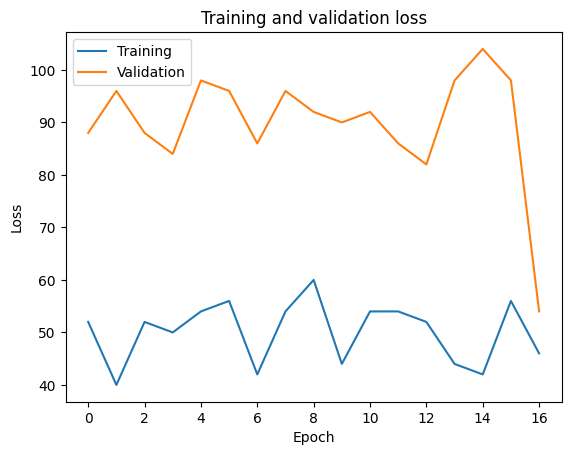

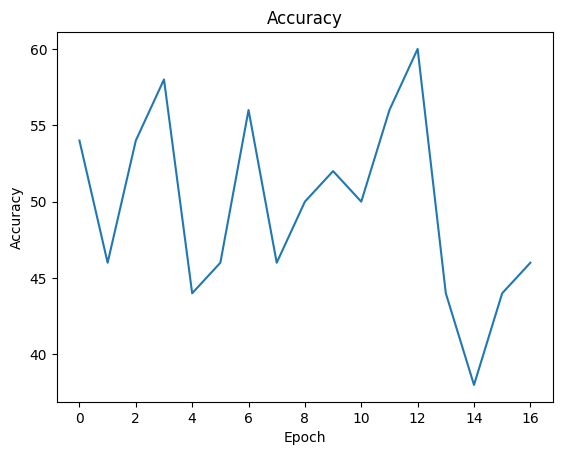

In [62]:
final_model = train_model(lr=0.016, gamma=0.281, epochs=17)

Save model:

In [63]:
# Save model
model_scripted = torch.jit.script(final_model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

Load model for testing:

In [64]:
fmodel = torch.jit.load('model_scripted.pt')
fmodel.eval()

RecursiveScriptModule(
  original_name=gru_model
  (embedding): RecursiveScriptModule(original_name=Embedding)
  (gru): RecursiveScriptModule(original_name=GRU)
  (fc): RecursiveScriptModule(original_name=Linear)
)

Define test function:

In [65]:
def test_gru(model, criterion):
  with torch.no_grad():
    for epoch in range(1):
      model.eval()
      test_losses = []
      running_loss = 0.0
      running_corrects = 0
      preds = []
      actuals = []
      for reviews, sentiment in test_loader:
        reviews = reviews.type(torch.LongTensor)
        output = model(reviews)
        outputs = (output > 0.5).float()
        outputs = outputs.squeeze(1)
        sentiment = sentiment.type(torch.FloatTensor).requires_grad_()
        test_loss = criterion(outputs, sentiment)
        running_loss += test_loss.item()
        test_losses.append(test_loss.item())
        preds.append(outputs)
        actuals.append(sentiment)
        test_acc = torch.sum(outputs == sentiment)
        running_corrects += test_acc

      accuracy = test_acc / len(outputs) * 100
      print(f"Loss: {test_loss:.3f}")
      print(f"Test accuracy: {accuracy:.3f}")
      return(test_loss, accuracy, preds, actuals)

Test final model:

In [66]:
criterion = nn.BCELoss()
test_loss, accuracy, preds, actuals = test_gru(fmodel, criterion)

Loss: 52.000
Test accuracy: 48.000
